# Simulation Notebook: Illustrations for Detection Taxonomy & Equilibrium Results


This notebook provides **self-contained simulations** to illustrate the statements in the attached paper
*Incorporating Taxonomies of Cyber Incidents into Detection Networks for Improved Detection Performance* (Warnick, 2025).

We simulate five key ideas:

1. **Continuity under conditioning (Theorem 1):** Precision/Recall of a conditioned detection vary continuously
   in the thresholds of the conditioning detections.
2. **Monotone effects of conditioning (Theorem 2):** Precision of a conditioned detection increases with the precision
   of positive-conditioning parents, and decreases with the precision of negative-conditioning parents (and the reciprocal
   statements for recall; cf. Proposition 1).
3. **Root/subtaxonomy conditioning (Theorem 3):** Conditioning a specific detection on a coarser, exhaustive parent
   detection (root of its path) uniformly increases precision (and lowers recall).
4. **Multi-threshold detection as a network (Theorem 4):** Brief constructive demonstration that multi-threshold
   logic induces a small DAG of conditional sub-detections.
5. **Existence of an equilibrium (Theorem 5):** Using the provided `TaxonomyBayesianNetwork` class, we run a
   coordinate-descent search that balances precision vs recall per node; we visualize before/after performance.

> **Note:** All plots use matplotlib only (no seaborn), one plot per figure, and default colors.



### Setup

We will:
- Import the two provided helper classes.
- Define small utilities to generate synthetic precision/recall as functions of a threshold `λ` and to simulate conditioned detections.
- Keep simulations lightweight but representative.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Local project imports
import sys, os
sys.path.insert(0, "/mnt/data")  # ensure imports work in this environment

from PerformanceGraphsClass import TaxonomyBayesianNetwork, _make_demo_taxonomy
from TaxonomyNodeClass import TaxonomyNode

# ---------- Generic precision/recall models ----------
def logistic(x):
    return 1/(1+np.exp(-x))

def recall_lambda(lam, sens=0.7, scale=8.0):
    # Higher λ => stricter => lower recall
    return logistic(scale*(sens - lam))

def precision_lambda(lam, spec=0.7, scale=8.0):
    # Higher λ => stricter => higher precision
    return logistic(scale*(lam - (1-spec)))

def pr_pair(lam, sens=0.7, spec=0.7, scale=8.0):
    return precision_lambda(lam, spec, scale), recall_lambda(lam, sens, scale)

# ---------- Conditioned detections model ----------
# D2 conditioned on D1: D2 can only fire if D1 fired.
# We parameterize "true positives" as underlying probability mass and form empirical precision/recall from Monte Carlo.

rng = np.random.default_rng(7)

def simulate_conditioned(N, lam1, lam2, sens1=0.7, spec1=0.7, sens2=0.6, spec2=0.65, scale=8.0, negative_parent=False):
    # Ground-truth positives (class P) appear with fixed prevalence
    prevalence = 0.2
    C = rng.random(N) < prevalence

    # D1 base behavior (unconditioned) as a function of λ1
    P1, R1 = pr_pair(lam1, sens1, spec1, scale)

    # Simulate D1
    D1 = np.zeros(N, dtype=bool)
    # True positives for D1
    D1[C] = rng.random(C.sum()) < R1
    # False positives for D1
    idxN = ~C
    D1[idxN] |= rng.random(idxN.sum()) < (1 - P1)  # 1-precision approximates FP propensity

    # D2 base behavior ignoring conditioning
    P2, R2 = pr_pair(lam2, sens2, spec2, scale)

    # For conditioning:
    if not negative_parent:
        # D2 only fires among items where D1 fired
        mask = D1
    else:
        # D2 only fires if D1 did NOT fire
        mask = ~D1

    D2 = np.zeros(N, dtype=bool)
    # Among masked positives, D2 recall applies
    masked_pos = mask & C
    D2[masked_pos] = rng.random(masked_pos.sum()) < R2
    # Among masked negatives, FP rate for D2 approximated from precision
    masked_neg = mask & (~C)
    D2[masked_neg] |= rng.random(masked_neg.sum()) < (1 - P2)

    # Compute empirical precision/recall for D1 and D2
    def pr_stats(D, C):
        TP = np.logical_and(D, C).sum()
        FP = np.logical_and(D, ~C).sum()
        FN = np.logical_and(~D, C).sum()
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        return precision, recall

    p1, r1 = pr_stats(D1, C)
    p2, r2 = pr_stats(D2, C)
    return (p1, r1), (p2, r2)



## Theorem 1: Continuity under conditioning

We visualize the surface \( (\lambda_1, \lambda_2) \mapsto \text{Precision}(D_2\,|\,D_1) \)
by Monte Carlo simulation. As we vary the *conditioning* threshold \(\lambda_1\)
(and the conditioned threshold \(\lambda_2\)), the resulting precision varies smoothly.


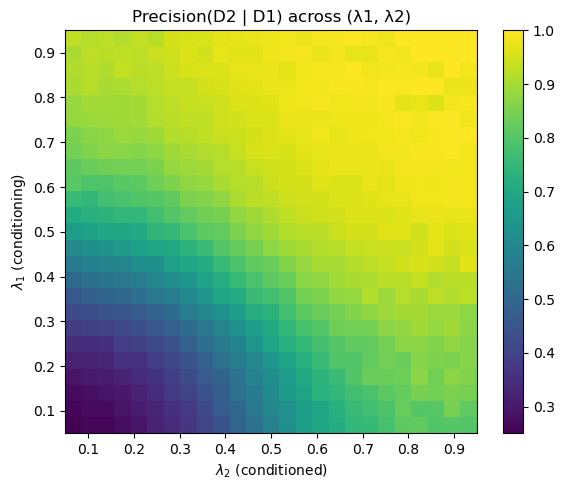

In [2]:

# Grid of (lam1, lam2)
grid = np.linspace(0.05, 0.95, 25)
Psurf = np.zeros((grid.size, grid.size))

for i, l1 in enumerate(grid):
    for j, l2 in enumerate(grid):
        (_, _), (p2, r2) = simulate_conditioned(
            N=20000, lam1=l1, lam2=l2, sens1=0.72, spec1=0.75, sens2=0.65, spec2=0.7, scale=8.0
        )
        Psurf[i, j] = p2  # precision of the conditioned detection D2|D1

plt.figure(figsize=(6,5))
plt.imshow(Psurf, origin="lower", extent=[grid.min(), grid.max(), grid.min(), grid.max()], aspect="auto")
plt.xlabel(r"$\lambda_2$ (conditioned)")
plt.ylabel(r"$\lambda_1$ (conditioning)")
plt.title("Precision(D2 | D1) across (λ1, λ2)")
plt.colorbar()
plt.tight_layout()
plt.savefig("theorem1_precision_surface.png", dpi=150, bbox_inches="tight")
plt.show()



## Theorem 2 (and Proposition 1): Monotone effects of conditioning

We sweep \(\lambda_1\) to induce a range of \(\text{Precision}(D_1)\). For each, we measure
\(\text{Precision}(D_2\,|\,D_1)\). We also test a **negative parent** variant where
\(D_2\) only fires when \(D_1\) does **not** fire; precision is then anti-monotone.

We repeat with recall to illustrate the reciprocal statement (Proposition 1).


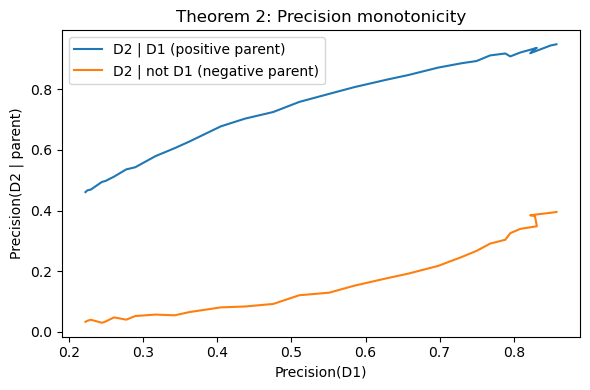

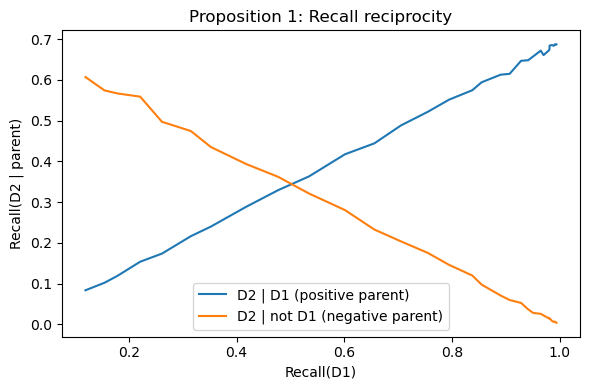

In [3]:

lam1s = np.linspace(0.05, 0.95, 31)
p1s, p2_given_p_s, p2_given_not_s = [], [], []
r1s, r2_given_p_s, r2_given_not_s = [], [], []

l2 = 0.5  # hold D2 threshold fixed
for l1 in lam1s:
    (p1, r1), (p2pos, r2pos) = simulate_conditioned(30000, l1, l2, negative_parent=False)
    (_, _), (p2neg, r2neg) = simulate_conditioned(30000, l1, l2, negative_parent=True)
    p1s.append(p1); r1s.append(r1)
    p2_given_p_s.append(p2pos); p2_given_not_s.append(p2neg)
    r2_given_p_s.append(r2pos); r2_given_not_s.append(r2neg)

# Precision monotonicity
plt.figure(figsize=(6,4))
plt.plot(p1s, p2_given_p_s, label="D2 | D1 (positive parent)")
plt.plot(p1s, p2_given_not_s, label="D2 | not D1 (negative parent)")
plt.xlabel("Precision(D1)")
plt.ylabel("Precision(D2 | parent)")
plt.title("Theorem 2: Precision monotonicity")
plt.legend()
plt.tight_layout()
plt.savefig("theorem2_precision_monotonicity.png", dpi=150, bbox_inches="tight")
plt.show()

# Recall reciprocal
plt.figure(figsize=(6,4))
plt.plot(r1s, r2_given_p_s, label="D2 | D1 (positive parent)")
plt.plot(r1s, r2_given_not_s, label="D2 | not D1 (negative parent)")
plt.xlabel("Recall(D1)")
plt.ylabel("Recall(D2 | parent)")
plt.title("Proposition 1: Recall reciprocity")
plt.legend()
plt.tight_layout()
plt.savefig("prop1_recall_relationship.png", dpi=150, bbox_inches="tight")
plt.show()



## Theorem 3: Conditioning on a coarser, exhaustive parent raises precision

We construct **coarse** event \(C_m\) and **fine** event \(C_n\) with the property \(C_n \Rightarrow C_m\).
We compare the precision of \(D_n\) vs \(D_n\,|\,D_m\) across thresholds; the conditioned version is uniformly higher.


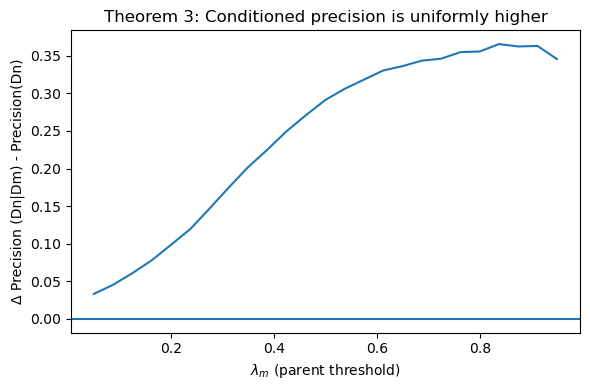

In [4]:

def simulate_root_subtaxonomy(N, lam_parent, lam_child, scale=8.0):
    # Define a coarse event Cm with prevalence 0.3; the fine event Cn occurs only when Cm occurs (subset)
    rng = np.random.default_rng(11)
    Cm = rng.random(N) < 0.30
    Cn = np.zeros(N, dtype=bool)
    # Given Cm, Cn happens with some conditional probability
    Cn[Cm] = rng.random(Cm.sum()) < 0.5  # Cn subset of Cm

    # Base Dm and Dn behavior
    Pm, Rm = pr_pair(lam_parent, sens=0.75, spec=0.75, scale=scale)
    Pn, Rn = pr_pair(lam_child,  sens=0.65, spec=0.70, scale=scale)

    # Simulate Dm
    Dm = np.zeros(N, dtype=bool)
    Dm[Cm] = rng.random(Cm.sum()) < Rm
    idxNm = ~Cm
    Dm[idxNm] |= rng.random(idxNm.sum()) < (1 - Pm)

    # Unconditioned Dn
    Dn = np.zeros(N, dtype=bool)
    Dn[Cn] = rng.random(Cn.sum()) < Rn
    idxNn = ~Cn
    Dn[idxNn] |= rng.random(idxNn.sum()) < (1 - Pn)

    # Conditioned Dn | Dm (only fires when Dm fired)
    mask = Dm
    Dn_cond = np.zeros(N, dtype=bool)
    pos = mask & Cn
    Dn_cond[pos] = rng.random(pos.sum()) < Rn
    neg = mask & (~Cn)
    Dn_cond[neg] |= rng.random(neg.sum()) < (1 - Pn)

    def precision(D, C):  # precision only for this theorem
        TP = np.logical_and(D, C).sum()
        FP = np.logical_and(D, ~C).sum()
        return TP / (TP + FP) if (TP + FP) > 0 else 0.0

    return precision(Dn, Cn), precision(Dn_cond, Cn)

grid = np.linspace(0.05, 0.95, 25)
delta = []  # Precision(Dn|Dm) - Precision(Dn)
for l in grid:
    p_uncond, p_cond = simulate_root_subtaxonomy(40000, lam_parent=l, lam_child=0.5)
    delta.append(p_cond - p_uncond)

plt.figure(figsize=(6,4))
plt.plot(grid, delta)
plt.axhline(0.0)
plt.xlabel(r"$\lambda_m$ (parent threshold)")
plt.ylabel("Δ Precision (Dn|Dm) - Precision(Dn)")
plt.title("Theorem 3: Conditioned precision is uniformly higher")
plt.tight_layout()
plt.savefig("theorem3_uniform_precision_gain.png", dpi=150, bbox_inches="tight")
plt.show()



## Theorem 4: Multi-threshold detection induces a small DAG

We give a short constructive demonstration: a detection with thresholds \((\lambda_1,\lambda_2,\lambda_3)\) can be
represented as a 3-node chain \(D_1(\lambda_1) \rightarrow D_2(\lambda_2) \rightarrow D_3(\lambda_3)\), where
the final detection fires only if all upstream sub-detections pass. We simulate performance of the final detection as we
change one sub-threshold while holding others fixed (continuous & monotone behavior emerge).


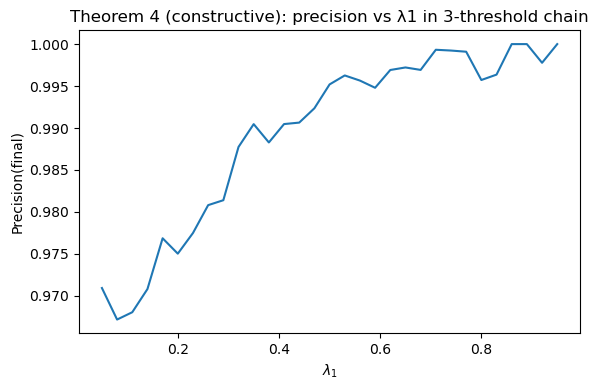

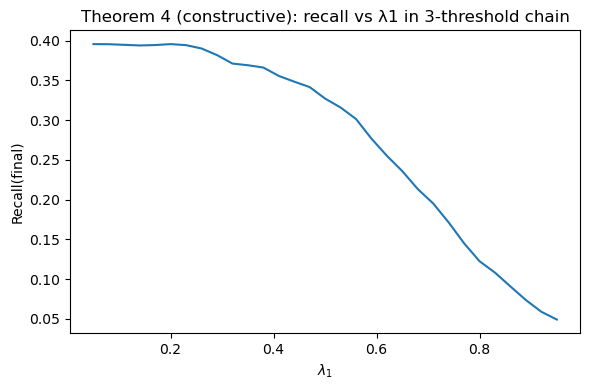

In [5]:

def simulate_multithreshold(N, lam1, lam2, lam3):
    rng = np.random.default_rng(23)
    prevalence = 0.25
    C = rng.random(N) < prevalence

    def pr(lam, sens, spec):
        return pr_pair(lam, sens, spec, scale=8.0)

    # Sub-detections in a chain (AND)
    P1, R1 = pr(lam1, 0.70, 0.75)
    P2, R2 = pr(lam2, 0.68, 0.72)
    P3, R3 = pr(lam3, 0.66, 0.70)

    # D1
    D1 = np.zeros(N, bool)
    D1[C] = rng.random(C.sum()) < R1
    idxN = ~C
    D1[idxN] |= rng.random(idxN.sum()) < (1 - P1)

    # D2 | D1
    D2 = np.zeros(N, bool)
    m2 = D1
    pos2 = m2 & C
    D2[pos2] = rng.random(pos2.sum()) < R2
    neg2 = m2 & (~C)
    D2[neg2] |= rng.random(neg2.sum()) < (1 - P2)

    # D3 | D2
    D3 = np.zeros(N, bool)
    m3 = D2
    pos3 = m3 & C
    D3[pos3] = rng.random(pos3.sum()) < R3
    neg3 = m3 & (~C)
    D3[neg3] |= rng.random(neg3.sum()) < (1 - P3)

    # PR for final detection
    TP = np.logical_and(D3, C).sum()
    FP = np.logical_and(D3, ~C).sum()
    FN = np.logical_and(~D3, C).sum()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    return precision, recall

lam1s = np.linspace(0.05, 0.95, 31)
prec, rec = [], []
for l1 in lam1s:
    p, r = simulate_multithreshold(30000, l1, 0.6, 0.6)
    prec.append(p); rec.append(r)

plt.figure(figsize=(6,4))
plt.plot(lam1s, prec)
plt.xlabel(r"$\lambda_1$")
plt.ylabel("Precision(final)")
plt.title("Theorem 4 (constructive): precision vs λ1 in 3-threshold chain")
plt.tight_layout()
plt.savefig("theorem4_multithreshold_precision.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(lam1s, rec)
plt.xlabel(r"$\lambda_1$")
plt.ylabel("Recall(final)")
plt.title("Theorem 4 (constructive): recall vs λ1 in 3-threshold chain")
plt.tight_layout()
plt.savefig("theorem4_multithreshold_recall.png", dpi=150, bbox_inches="tight")
plt.show()



## Theorem 5: Existence of an equilibrium (empirical demonstration)

We use `TaxonomyBayesianNetwork` to run the coordinate-descent search balancing precision and recall at each node
by minimizing \((\text{Precision} - \text{Recall})^2\). We visualize **before vs after** per-node metrics.

> The search in the class returns only final thresholds. We therefore compare scatter plots before and after to show
> the approach toward the balance line \(y = x\).


[iter 0] max Δλ = 0.39
[iter 1] max Δλ = 0


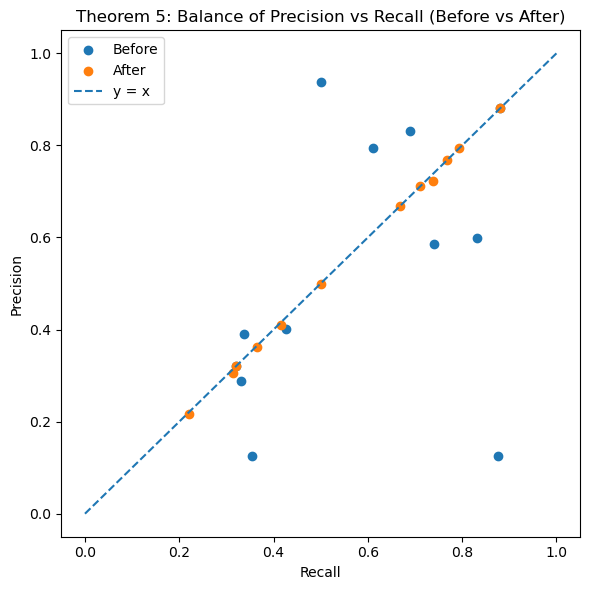

In [9]:

root = _make_demo_taxonomy()
tbn = TaxonomyBayesianNetwork(root)

# Before
perf0 = tbn.run_performance_analysis()

# Search
final_thresholds = tbn.equilibrium_search(max_iters= 100, tol= 1e-4, steps= 100, verbose= True)

# After
perf1 = tbn.run_performance_analysis(final_thresholds)

# Scatter: Recall (x) vs Precision (y) before and after
names = sorted(perf0.keys())
x0 = [perf0[n]["recall"] for n in names]
y0 = [perf0[n]["precision"] for n in names]
x1 = [perf1[n]["recall"] for n in names]
y1 = [perf1[n]["precision"] for n in names]

plt.figure(figsize=(6,6))
plt.scatter(x0, y0, label="Before")
plt.scatter(x1, y1, label="After")
# y=x line
xx = np.linspace(0,1,100)
plt.plot(xx, xx, linestyle="--", label="y = x")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Theorem 5: Balance of Precision vs Recall (Before vs After)")
plt.legend()
plt.tight_layout()
plt.savefig("theorem5_equilibrium_scatter.png", dpi=150, bbox_inches="tight")
plt.show()



## How to use this notebook

1. Run all cells from top to bottom.
2. Each section saves a figure (`.png`) in the working directory; embed them directly into your paper or slides.
3. If you want to tweak difficulty or shapes, adjust the sensitivity/specificity/scale parameters in the simulation
   utilities or grid sizes.

If you want, I can add **statistical tests** (e.g., monotonic trend checks) and **confidence bands** to quantify the
effects observed in the plots.
